

```
# augmentaion data with albumentation librairie 
```





In [2]:
!pip install albumentations

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 1.1 MB/s eta 0:00:001.3 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 11.4 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.3/210.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 13.3 MB/s eta 0:00:000:00:01m eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 14.6 MB/s eta 0:00:0031m16.0 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 16.9 MB/s eta 0:00:0031m19.5 MB/s eta 0:00:01


In [3]:
import albumentations as A        # For data augmentation
import cv2                        # For loading images
import matplotlib.pyplot as plt   # For plotting images
import numpy as np
# import random


In [4]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White
def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    witht,height=img.shape[1],img.shape[0]
    x_min, y_min, w, h,_= bbox
  
    x_min, y_min, w, h=float(x_min*witht),float(y_min*height),float(w*witht),float(h*height)
    x_min, x_max, y_min, y_max = round(x_min-w/2), round(x_min + w/2), round(y_min-h/2), round(y_min + h/2)
   
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

In [5]:
def read_file_txt(path,image):
  width,height,_=image.shape
  class_labels,bboxes=[],[]
  source_file = open(path)
  for line in source_file: 
          staff = line.split() 
          class_idx = int(staff[0])
          class_labels.append(class_idx)
          x_center, y_center, w, h = float(staff[1]), float(staff[2]), float(staff[3]), float(staff[4])
          # x1 = round(x_center-w/2)
          # y1 = round(y_center-h/2)
          # x2 = round(x_center+w/2)
          # y2 = round(y_center+h/2) 
          bboxes.append([x_center,y_center,w,h,str(class_idx)]) 
  return bboxes,class_labels

In [6]:
def Transformation(image,bboxes,transform):
  transformed = transform(image=image, bboxes=bboxes)
  return transformed['image'],transformed['bboxes']

In [7]:
def save_labels(path_labels, transformed_bboxes, class_labels):
    with open(path_labels, 'w') as fp:
        for box, cls_label in zip(transformed_bboxes, class_labels) :
            box_arry = np.array(box)
            fp.write(str(cls_label) + " ")
            for i in box_arry[:-1]:
                i = round(float(i) , 4)
                fp.write(str(i) + " ")
            fp.write("\n")  
           #print('Saving Labels File is [Done].')

In [8]:
import glob 
from PIL import Image
import numpy as np
transform = A.Compose([
  A.RandomCrop(width=2028, height=1536),
  A.HorizontalFlip(p=0.8),
  A.RandomBrightnessContrast(p=0.2),], bbox_params=A.BboxParams(format='yolo'))
def augmentation_data(source_images,source_labels,destination_images,destination_labels):
  images_dir=glob.glob(source_images+"/*")
  for filename in images_dir:
    image_name=filename.split(".")[0].split("/")[-1]
    txt_name=f'{source_labels}/{image_name}.txt'
    img_arr = cv2.imread(filename)
    img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
    bboxes,class_labels=read_file_txt(txt_name,img_arr)
    transformed_image,transformed_bboxes=Transformation(img_arr,bboxes,transform)
    if (len(transformed_bboxes)!=0):
      print(image_name)
      # print(img_arr.shape)
      path_image=f"{destination_images}/{image_name}_A.JPG"
      path_labels=f"{destination_labels}/{image_name}_A.txt"
      cv2.imwrite(path_image, transformed_image)
      save_labels(path_labels,transformed_bboxes,class_labels)
    else:
      pass

In [31]:
source_images="/train/images"
source_labels="/train/labels"
destination_images="/Albumentation/images"
destination_labels="/Albumentation/labels"
augmentation_data(source_images,source_labels,destination_images,destination_labels)

In [41]:
ls /Albumentation/images

DJI_20220926221946_0002_Z_A.JPG  DJI_20221013094423_0004_Z_A.JPG
DJI_20220926222151_0014_Z_A.JPG  DJI_20221013094429_0006_Z_A.JPG
DJI_20220926222203_0016_Z_A.JPG  DJI_20221013103259_0001_Z_A.JPG
DJI_20220926222318_0027_Z_A.JPG  DJI_20221013103359_0001_Z_A.JPG
DJI_20220926222415_0036_Z_A.JPG  DJI_20221013103423_0001_Z_A.JPG
DJI_20220926222419_0037_Z_A.JPG  DJI_20221013103432_0001_Z_A.JPG
DJI_20220929104433_0009_Z_A.JPG  DJI_20221013103650_0001_Z_A.JPG
DJI_20220929104439_0011_Z_A.JPG  DJI_20221013103941_0001_Z_A.JPG
DJI_20220929104442_0012_Z_A.JPG  DJI_20221013103944_0001_Z_A.JPG
DJI_20220929131419_0005_Z_A.JPG  DJI_20221013104021_0001_Z_A.JPG
DJI_20220929134312_0001_Z_A.JPG  DJI_20221013104048_0001_Z_A.JPG
DJI_20220929134318_0002_Z_A.JPG  DJI_20221013110641_0002_Z_A.JPG
DJI_20220929134324_0004_Z_A.JPG  DJI_20221013110650_0005_Z_A.JPG
DJI_20220929134330_0006_Z_A.JPG  DJI_20221013110723_0009_Z_A.JPG
DJI_20220929134345_0007_Z_A.JPG  DJI_20221013110732_0012_Z_A.JPG
DJI_20220929134356_0010_Z

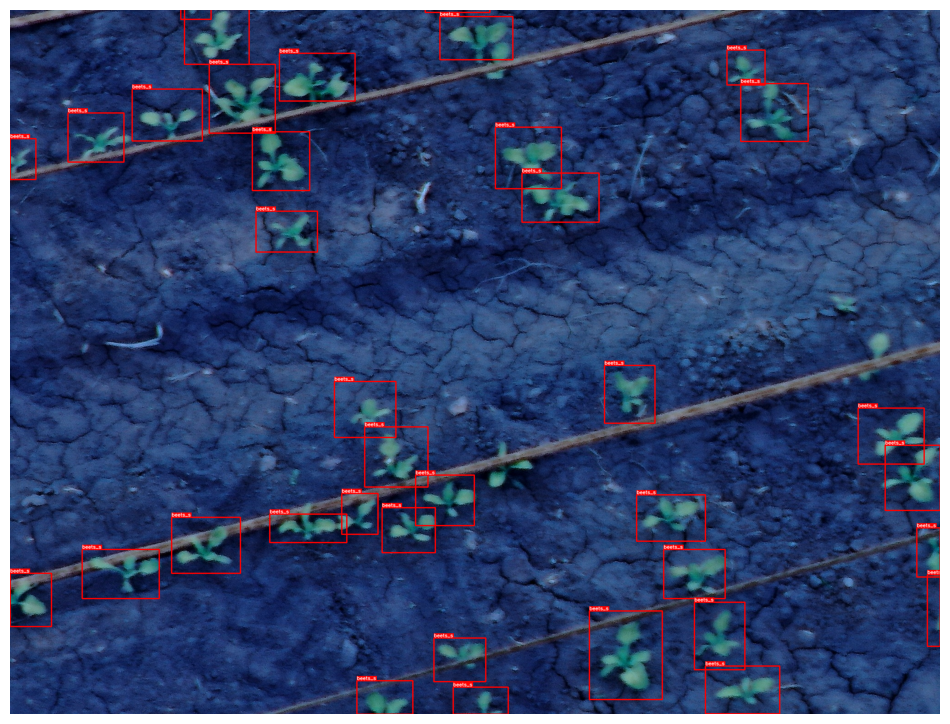

In [52]:
image = cv2.imread('Albumentation/images/DJI_20221011112332_0012_Z_A.JPG')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
path="Albumentation/labels/DJI_20221011112332_0012_Z_A.txt"
bboxes,class_labels=read_file_txt(path,image)
category_id_to_name = {0: 'beets_s'}
visualize(image, bboxes,class_labels, category_id_to_name)